## Load Data from CSVs

In [1]:
import unicodecsv


In [2]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.

def read_csvfile(filename):
    with open(filename, 'rb') as f: 
        reader = unicodecsv.DictReader(f)
        
        return list(reader)
    
enrollments_filename = 'enrollments.csv'
engagement_filename = 'daily_engagement.csv'
submissions_filename = 'project_submissions.csv'

enrollments = read_csvfile(enrollments_filename)
#print enrollments[0]

daily_engagement = read_csvfile(engagement_filename)
#print "\n", daily_engagement[0]

project_submissions = read_csvfile(submissions_filename)
#print "\n",project_submission[0]

## Fixing Data Types

In [3]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [4]:
# Clean up the data types in the engagement table

for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [5]:
# Clean up the data types in the submissions table

for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

## Investigating the Data

In [6]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys) in each table.
def get_unique_students(std_dict):
    unique_items_in_dict = set()

    for elem in std_dict:
        if 'account_key' in elem.keys():
            unique_items_in_dict.add(elem['account_key'])
        else:
            unique_items_in_dict.add(elem['acct']) 
        
    return unique_items_in_dict

enrollment_num_rows = len(enrollments)
enrollment_unique_students = get_unique_students(enrollments)
enrollment_num_unique_students = len(enrollment_unique_students)
print "unique enrollments: ", enrollment_num_unique_students

engagement_num_rows = len(daily_engagement)
engagement_unique_students = get_unique_students(daily_engagement)
engagement_num_unique_students = len(engagement_unique_students)
print "\nunique daily engagement: ", engagement_num_unique_students

submission_num_rows = len(project_submissions)
submission_unique_students = get_unique_students(project_submissions)
submission_num_unique_students = len(submission_unique_students)
print "\nunique project submissions: ", submission_num_unique_students


unique enrollments:  1302

unique daily engagement:  1237

unique project submissions:  743


## Problems in the Data

In [7]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".
for elem in daily_engagement:
    elem['account_key'] = elem['acct']
    del elem['acct']
    
daily_engagement[0]['account_key']

u'0'

## Missing Engagement Records

In [8]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.
item = 0
for elem in enrollment_unique_students:
    if elem not in engagement_unique_students:
        item = elem
        break

for elem in enrollments:
    if elem['account_key'] == item:
        print elem

{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2015, 4, 4, 0, 0), u'account_key': u'1145', u'cancel_date': datetime.datetime(2015, 4, 4, 0, 0), u'days_to_cancel': 0}


## Checking for More Problem Records

In [9]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.
no_of_missing = 0
for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in engagement_unique_students and (enrollment['days_to_cancel'] > 0 or enrollment['days_to_cancel'] is None):
        no_of_missing += 1
        
print no_of_missing

3


## Tracking Down the Remaining Problems

In [10]:
# Create a set of the account keys for all Udacity test accounts

udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
        
len(udacity_test_accounts)

6

In [11]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts

def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
            
    return non_udacity_data

In [12]:
# Remove Udacity test accounts from all three tables

non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


## Refining the Question

In [13]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students = {}
for enrollment in non_udacity_enrollments:
    if enrollment['days_to_cancel'] is None or enrollment['days_to_cancel'] > 7:
        if enrollment['account_key'] not in paid_students or paid_students[enrollment['account_key']] < enrollment['join_date']:
            paid_students[enrollment['account_key']] = enrollment['join_date']

len(paid_students)

995

## Getting Data from First Week

In [14]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.

def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [15]:
# Get the list of student excluding trails

def remove_free_trial_cancels(data):
    new_data = []
    
    for t_data in data:
        if t_data['account_key'] in paid_students:
            new_data.append(t_data)
            
    return new_data

paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagements = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

print len(paid_enrollments)
print len(paid_engagements)
print len(paid_submissions)
    

1293
134549
3618


In [25]:
for engagement_record in paid_engagements:
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0

In [26]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

paid_engagement_in_first_week = []
for engagement in paid_engagements:
    
    join_date = paid_students[engagement['account_key']]
    engagement_record_date = engagement['utc_date']
    
    if within_one_week(join_date, engagement_record_date):
        paid_engagement_in_first_week.append(engagement)
        
len(paid_engagement_in_first_week)
        

6919

## Exploring Student Engagement

In [27]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.

engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [28]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)

total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
        
    total_minutes_by_account[account_key] = total_minutes

In [29]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = total_minutes_by_account.values()
print 'Mean:', np.mean(total_minutes)
print 'Standard deviation:', np.std(total_minutes)
print 'Minimum:', np.min(total_minutes)
print 'Maximum:', np.max(total_minutes)

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


## Debugging Data Analysis Code

In [30]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.

'''
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0
'''

'\ndef within_one_week(join_date, engagement_date):\n    time_delta = engagement_date - join_date\n    return time_delta.days < 7 and time_delta.days >= 0\n'

## Lessons Completed in First Week

In [31]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.

total_lessons_by_account = {}
for account, total_engagement in engagement_by_account.items():
    total_lessons = 0
    for engagement_record in total_engagement:
        total_lessons += engagement_record['lessons_completed']
        
    total_lessons_by_account[account] = total_lessons
    
total_lessons = total_lessons_by_account.values()   
print 'Avg: ', np.mean(total_lessons)
print 'Std: ', np.std(total_lessons)
print 'Min: ', np.min(total_lessons)
print 'Max: ', np.max(total_lessons)


Avg:  1.63618090452
Std:  3.00256129983
Min:  0
Max:  36


## Number of Visits in First Week

In [63]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.

days_visited_by_account = {}
for account, total_engagement in engagement_by_account.items():
    total_lessons = 0
    for engagement_record in total_engagement:
        total_lessons += engagement_record['has_visited']
        
    days_visited_by_account[account] = total_lessons
    
total_lessons = days_visited_by_account.values() 
print 'Avg: ', np.mean(total_lessons)
print 'Std: ', np.std(total_lessons)
print 'Min: ', np.min(total_lessons)
print 'Max: ', np.max(total_lessons)

995
Avg:  2.86733668342
Std:  2.25519800292
Min:  0
Max:  7


In [47]:
paid_submissions[4]

{u'account_key': u'434',
 u'assigned_rating': u'INCOMPLETE',
 u'completion_date': datetime.datetime(2015, 3, 3, 0, 0),
 u'creation_date': datetime.datetime(2015, 2, 17, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

## Splitting out Passing Students

In [60]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

passing_engagement_project = set()

for engagement_record in paid_submissions:
    rating = engagement_record['assigned_rating']
    if engagement_record['lesson_key'] in subway_project_lesson_keys:
        if rating == 'PASSED' or rating == 'DISTINCTION':
            passing_engagement_project.add(engagement_record['account_key'])
            
#print len(passing_engagement_project)

passing_engagement = []
non_passing_engagement = []
for engagement_rec  in paid_engagement_in_first_week:
    if engagement_rec['account_key'] in passing_engagement_project:
        passing_engagement.append(engagement_rec)
    else:
        non_passing_engagement.append(engagement_rec)

#print len(paid_engagement_in_first_week)
print len(passing_engagement)
print len(non_passing_engagement)

4527
2392


## Comparing the Two Student Groups

In [70]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).
print passing_engagement[0]

print "\n"

total_lessons_passing = {}
for record in passing_engagement:        
    total_lessons_passing[record['account_key']] = record['lessons_completed']
    
total_lessons = total_lessons_passing.values()   
print 'Avg: ', np.mean(total_lessons)
print 'Std: ', np.std(total_lessons)
print 'Min: ', np.min(total_lessons)
print 'Max: ', np.max(total_lessons)

print "\n"

total_lessons_non_passing = {}
for record in non_passing_engagement:        
    total_lessons_non_passing[record['account_key']] = record['lessons_completed']
    
total_lessons = total_lessons_non_passing.values()   
print 'Avg: ', np.mean(total_lessons)
print 'Std: ', np.std(total_lessons)
print 'Min: ', np.min(total_lessons)
print 'Max: ', np.max(total_lessons)

print "\n"

total_hours_passing = {}
for record in passing_engagement:        
    total_hours_passing[record['account_key']] = record['total_minutes_visited']
    
total_lessons = total_hours_passing.values()   
print 'Avg: ', np.mean(total_lessons)
print 'Std: ', np.std(total_lessons)
print 'Min: ', np.min(total_lessons)
print 'Max: ', np.max(total_lessons)

print "\n"

total_hours_non_passing = {}
for record in non_passing_engagement:        
    total_hours_non_passing[record['account_key']] = record['total_minutes_visited']
    
total_lessons = total_hours_non_passing.values()   
print 'Avg: ', np.mean(total_lessons)
print 'Std: ', np.std(total_lessons)
print 'Min: ', np.min(total_lessons)
print 'Max: ', np.max(total_lessons)

{u'lessons_completed': 0, u'num_courses_visited': 1, 'has_visited': 1, u'total_minutes_visited': 11.6793745, u'projects_completed': 0, 'account_key': u'0', u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}


Avg:  0.301391035549
Std:  0.694679212846
Min:  0
Max:  6


Avg:  0.137931034483
Std:  0.585699577637
Min:  0
Max:  6


Avg:  54.2964857849
Std:  93.1419538392
Min:  0.0
Max:  733.774659167


Avg:  20.1359475316
Std:  60.7016245569
Min:  0.0
Max:  518.360104833


## Making Histograms

(array([ 508.,  103.,    0.,   24.,    0.,    7.,    3.,    0.,    1.,    1.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ]),
 <a list of 10 Patch objects>)

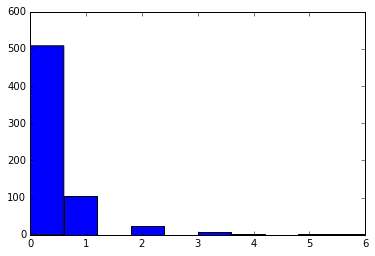

In [78]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(total_lessons_passing.values())

(array([ 321.,   16.,    0.,    6.,    0.,    2.,    2.,    0.,    0.,    1.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ]),
 <a list of 10 Patch objects>)

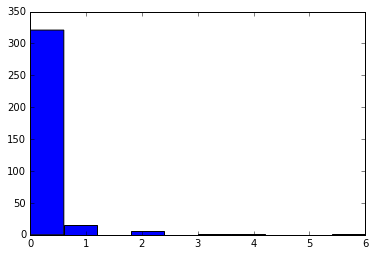

In [79]:

plt.hist(total_lessons_non_passing.values())

## Improving Plots and Sharing Findings

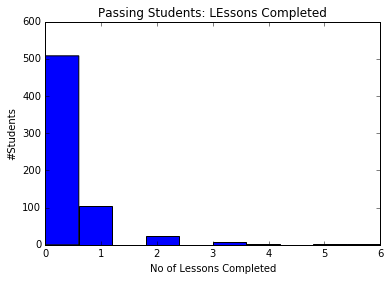

In [82]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.

plt.hist(total_lessons_passing.values(), bins = 10)
plt.xlabel("No of Lessons Completed")
plt.ylabel("#Students")
plt.title("Passing Students: Lessons Completed")

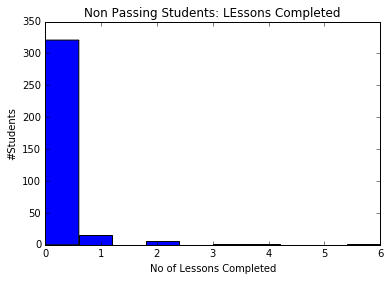

In [83]:
plt.hist(total_lessons_non_passing.values(), bins = 10)
plt.xlabel("No of Lessons Completed")
plt.ylabel("#Students")
plt.title("Non Passing Students: Lessons Completed")

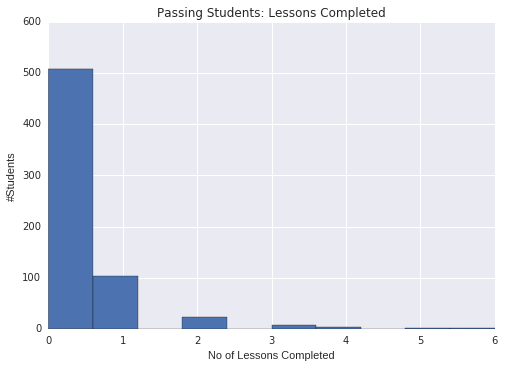

In [85]:
import seaborn as sns

plt.hist(total_lessons_passing.values(), bins = 10)
plt.xlabel("No of Lessons Completed")
plt.ylabel("#Students")
plt.title("Passing Students: Lessons Completed")

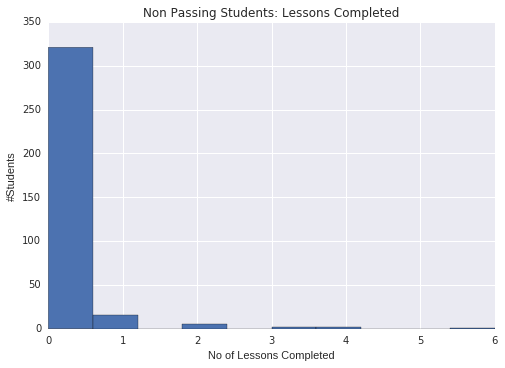

In [86]:
plt.hist(total_lessons_non_passing.values(), bins = 10)
plt.xlabel("No of Lessons Completed")
plt.ylabel("#Students")
plt.title("Non Passing Students: Lessons Completed")